In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import autograd.numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar

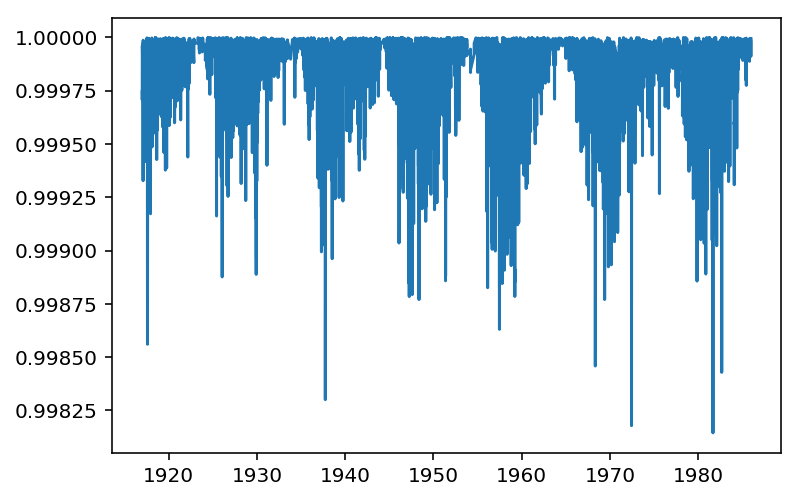

In [18]:
from astropy.time import Time
from scipy.optimize import minimize 

lc = np.load('mrspoc_lc.npy')
times = lc[:, 0]
fluxes = lc[:, 1]

plt.plot(Time(times, format='jd').decimalyear, fluxes)

In [19]:
julian_date_ints = Time(times, format='jd').jd.astype(int)
jd_min = np.min(julian_date_ints)
jd_max = np.max(julian_date_ints)
missing_dates = set(np.arange(jd_min, jd_max)).difference(julian_date_ints)

In [20]:
all_dates = np.concatenate([Time(times, format='jd').jd, list(missing_dates)])
all_fluxes = np.concatenate([fluxes, np.ones(len(missing_dates))])

sort = np.argsort(all_dates)

all_dates = all_dates[sort]
all_fluxes = all_fluxes[sort]

(1945, 1962)

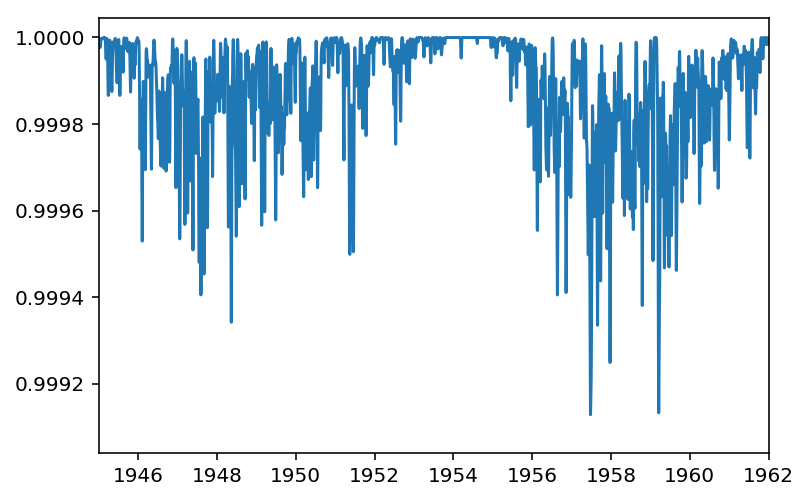

In [21]:
from scipy.ndimage import gaussian_filter1d
all_fluxes = gaussian_filter1d(all_fluxes, 3)
plt.plot(Time(all_dates, format='jd').decimalyear, all_fluxes)
plt.xlim([1945, 1962])

In [22]:
import celerite
from celerite import terms
import autograd.numpy as anp

class CustomTerm(terms.Term):
    """Decaying exponential"""
    parameter_names = ("log_a", "log_c", "log_P")

    def get_complex_coefficients(self, params):
        log_a, log_c, log_P = params
        return (
            np.exp(log_a), 0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )
    
class CustomTermNoDecay(terms.Term):
    """Non-decaying cosine"""

    parameter_names = ("log_a", "log_P")

    def get_complex_coefficients(self, params):
        log_a, log_P = params
        return (
            np.exp(log_a), 0,
            0, 2*np.pi*np.exp(-log_P),
        )

class CustomTermPositive(terms.Term):
    "Always positive decaying"
    parameter_names = ("log_a", "log_c", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_c, log_P = params
        return (
            np.exp(log_a), np.exp(log_c),
        )

    def get_complex_coefficients(self, params):
        log_a, log_c, log_P = params
        return (
            np.exp(log_a), 0.0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )

# Cycle
bounds = dict(log_a=(-30, 30), log_c=(-30, 30), log_P=(np.log(365*10), np.log(365*12)))
kernel = CustomTerm(log_a=-20, log_c=-9, log_P=np.log(365*10.5), bounds=bounds)

# # Cycle
# bounds = dict(log_a=(-30, 30), log_P=(np.log(365*10), np.log(365*12)))
# kernel = CustomTermNoDecay(log_a=-20, log_P=np.log(365*10.5), bounds=bounds)

# Annual
bounds = dict(log_a=(-30, 30), log_P=(np.log(360), np.log(370)))
kernel += CustomTermNoDecay(log_a=-20, log_P=np.log(365), bounds=bounds)

# Rotation
bounds = dict(log_a=(-30, 30), log_c=(-30, 30), log_P=(np.log(20), np.log(30)))
kernel += CustomTermPositive(log_a=-20, log_c=-2, log_P=np.log(26), bounds=bounds)

# kernel.freeze_parameter('terms[0]:log_c')
# kernel.freeze_parameter('terms[1]:log_c')
# kernel.freeze_parameter('terms[2]:log_c')

# kernel.freeze_parameter('terms[0]:log_P')
# kernel.freeze_parameter('terms[1]:log_P')
# kernel.freeze_parameter('terms[2]:log_P')

# bounds = dict(log_a=(-30, 30), log_c=(-30, 30), log_P=(np.log(365*9), np.log(365*11)))
# kernel = CustomTerm(log_a=-0.5, log_c=-9, log_P=np.log(365*10.5), bounds=bounds)

# bounds = dict(log_S0=(-30, 30), log_Q=(-1, 2), log_omega0=(np.log(2*np.pi/30), np.log(2*np.pi/20)))
# kernel = terms.SHOTerm(log_S0=0, log_Q=1, log_omega0=np.log(2*np.pi/26), bounds=bounds)


# bounds = dict(log_S0=(-30, 30), log_Q=(2, 3), log_omega0=(np.log(2*np.pi/(20*365)), np.log(2*np.pi/(5*365)))) #, np.log(2*np.pi/(5*365))))
# kernel += terms.SHOTerm(log_S0=3, log_Q=2, log_omega0=np.log(2*np.pi/(10.5*365)), bounds=bounds)


# bounds = dict(log_S0=(-30, 30), log_Q=(2, 3), log_omega0=(np.log(2*np.pi/400), np.log(2*np.pi/300))) #, np.log(2*np.pi/(5*365))))
# kernel += terms.SHOTerm(log_S0=0.5, log_Q=2, log_omega0=np.log(2*np.pi/(365)), bounds=bounds)

# kernel.freeze_paramete r('log_P')
# kernel.freeze_parameter('terms[1]:log_P')

x = all_dates - all_dates.mean()
yerr = 1e-6

mean = all_fluxes.mean()
y = all_fluxes - all_fluxes.mean() 

gp = celerite.GP(kernel)#, mean=1)
gp.compute(x, yerr)

In [23]:
from interpacf import autocorrelation

acf_measured = autocorrelation(y)

# plt.plot(acf_measured)
# plt.grid()

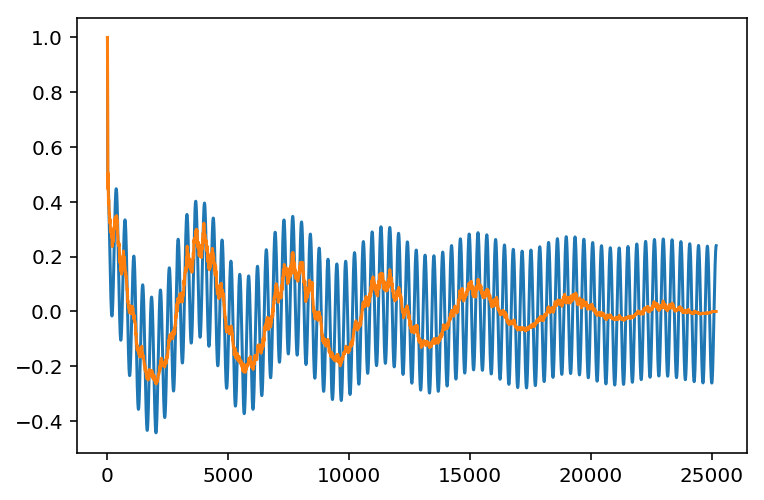

In [24]:
lags = np.arange(len(y))
acf_model = gp.kernel.get_value(lags)

plt.plot(lags, acf_model/acf_model.max())
plt.plot(lags, acf_measured/acf_measured.max())

# plt.xlim([0, 365*50])
# plt.xlim([0, 365*3])
# plt.xlim([0, 180])

In [25]:
# def neg_log_like(params, y, gp):
#     gp.kernel.set_parameter_vector(params)
#     acf_model = gp.kernel.get_value(lags)
#     acf_model = acf_model/acf_model.max()

#     return np.sum((acf_model - acf_measured/acf_measured.max())**2)

# initial_params = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()

# r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
# # gp.set_parameter_vector(r.x)

# acf_model = gp.kernel.get_value(lags)

# plt.plot(lags, acf_model/acf_model.max())
# plt.plot(lags, acf_measured/acf_measured.max())
# # plt.xlim([0, 100])

In [26]:

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

# initial_params = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()

# r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
# gp.set_parameter_vector(r.x)
# print(r)

def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

import emcee

# initial = np.array(r.x)
initial = gp.kernel.get_parameter_vector()
ndim, nwalkers = len(initial), 20
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 4000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 4000);
from corner import corner

#     corner(sampler.flatchain, labels=['$\log a$', '$\log c$', '$\log P$'])
#     # plt.savefig('paper_plots/corner.pdf', bbox_inches='tight')
#     plt.show()

# fig, ax = plt.subplots(figsize=(4, 3))
# gp_period = np.exp(sampler.flatchain[:, -2])
# ax.hist(gp_period, color='k', histtype='stepfilled')
# ax.set_xlabel('Rotation Period [d]')
# ax.set_yticks([])

# for s in ['right', 'top', 'left']:
#     ax.spines[s].set_visible(False)
# #     fig.savefig('paper_plots/period.pdf', bbox_inches='tight')
# plt.show()
sampler.pool.close()

Running burn-in...
Running production...


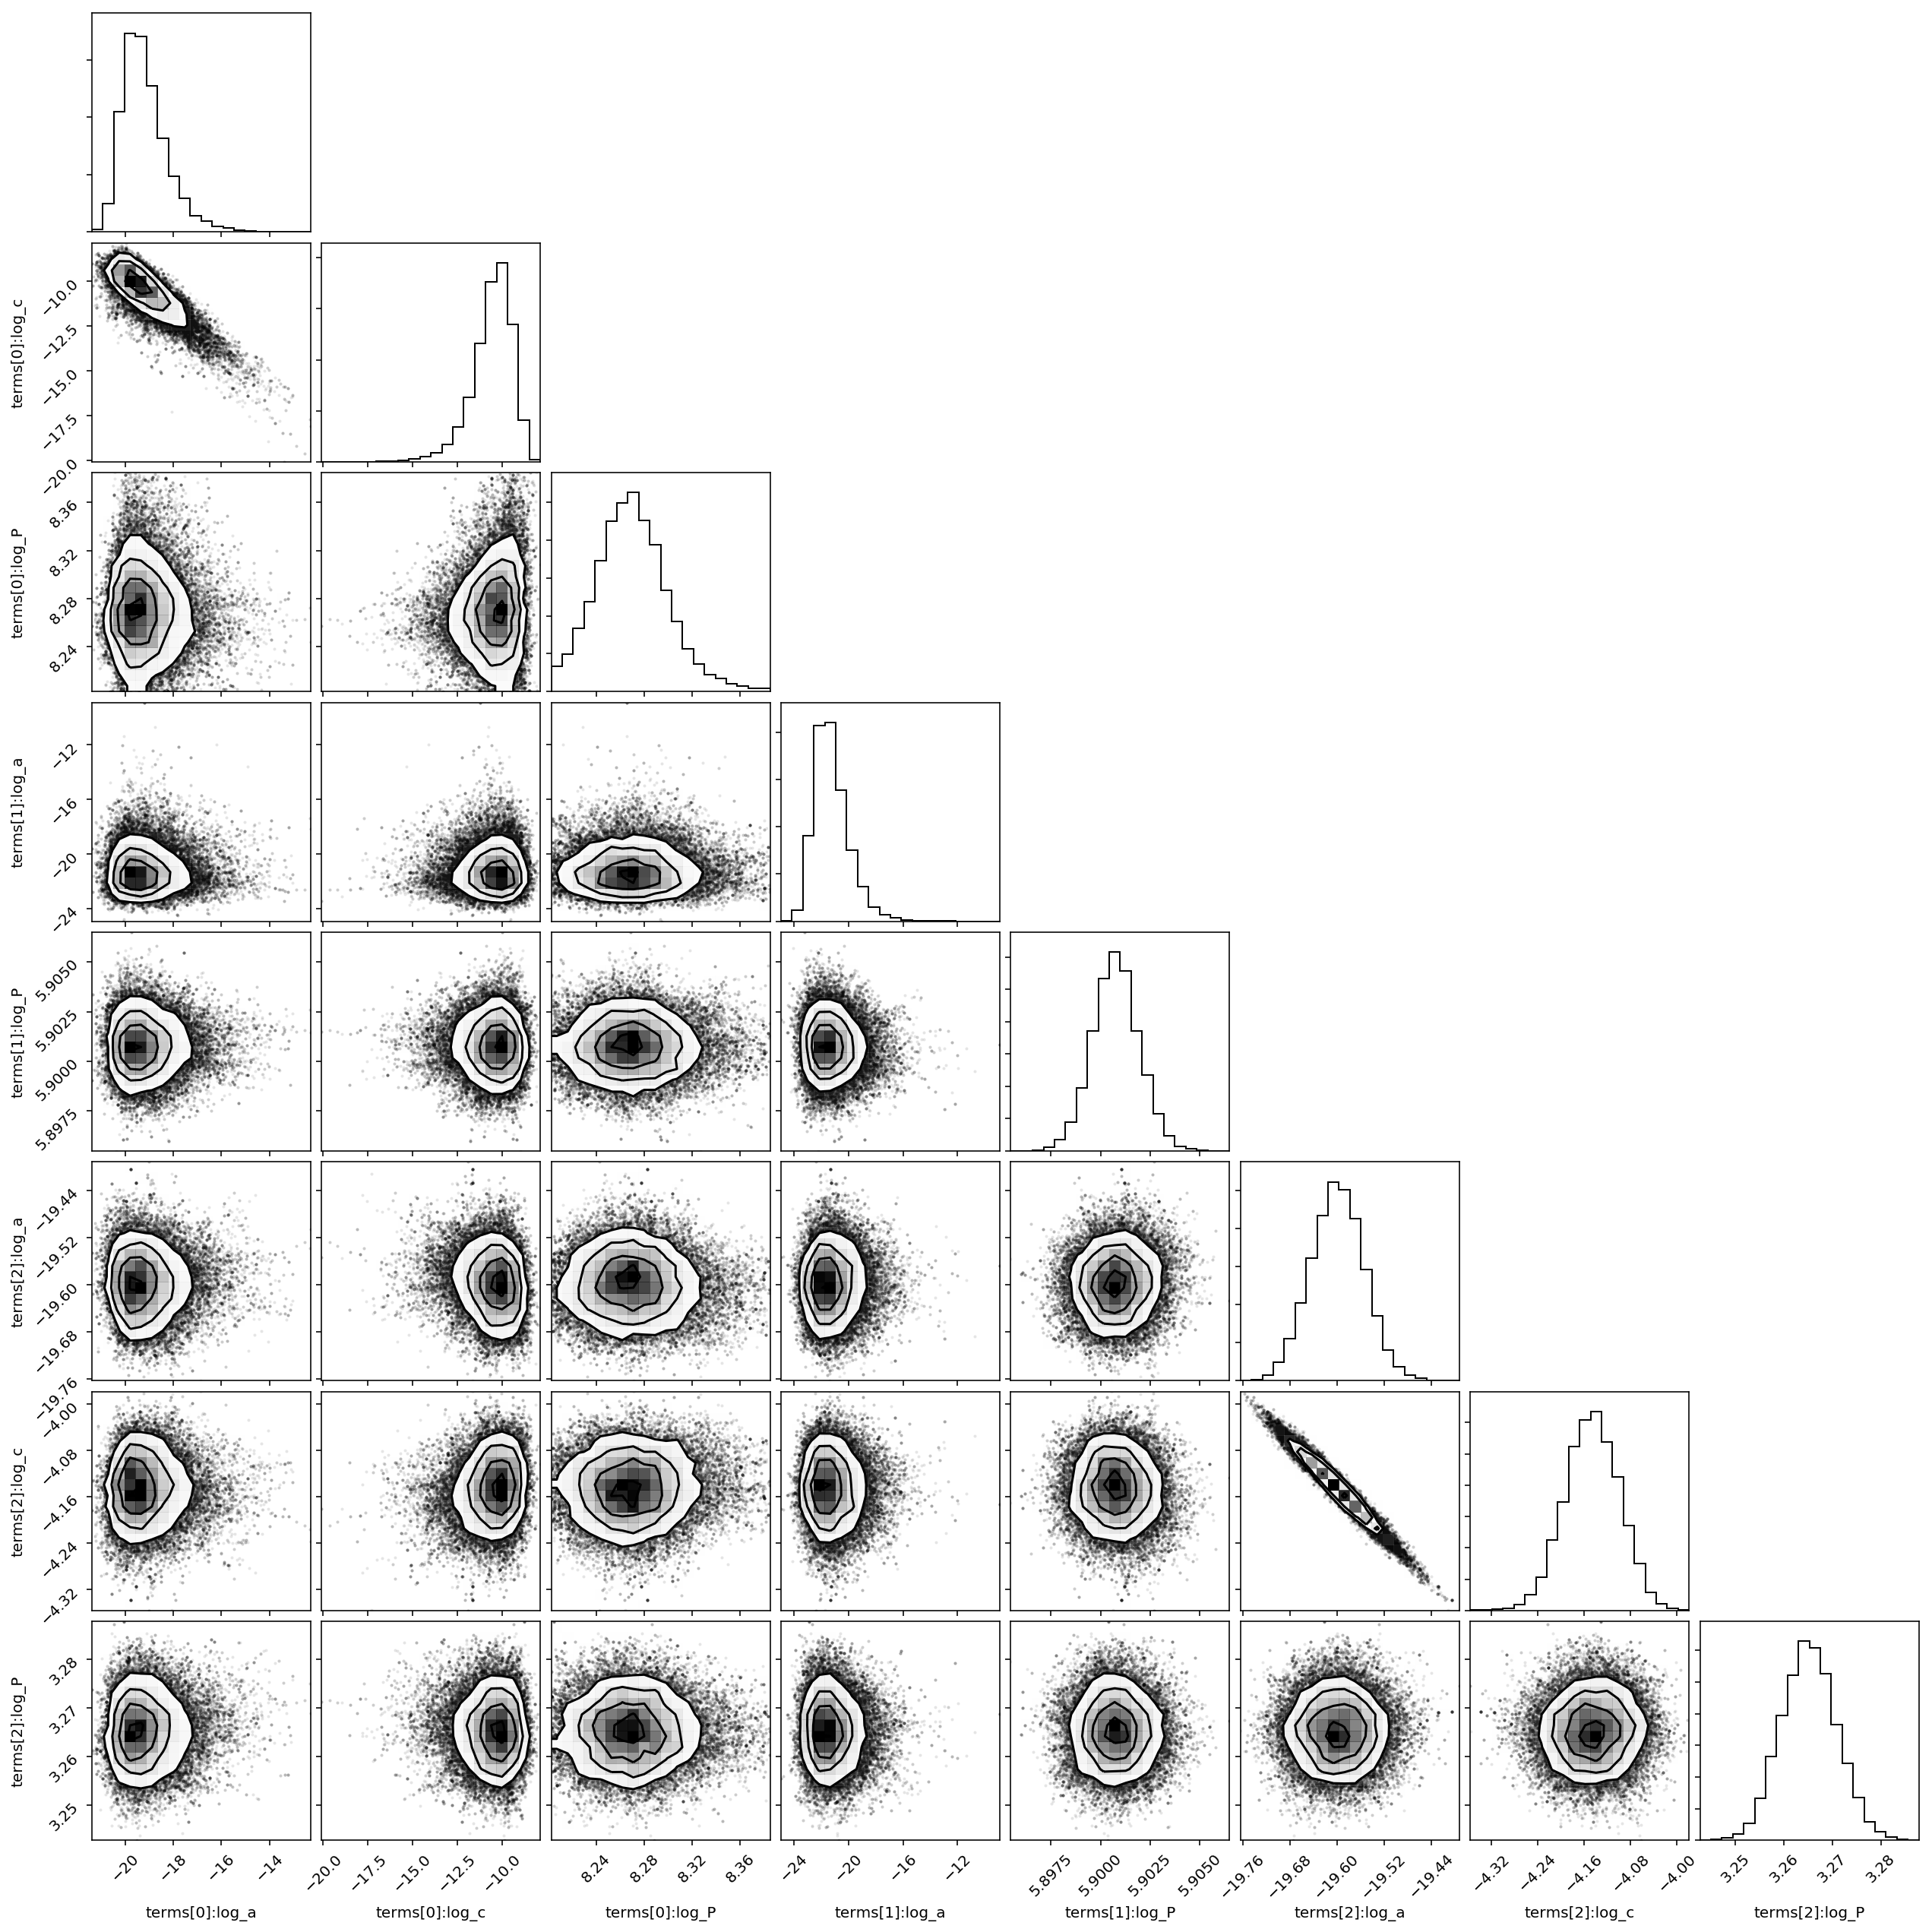

In [27]:
corner(sampler.flatchain, labels=gp.kernel.get_parameter_names())
plt.savefig('paper_plots/corner.png', bbox_inches='tight')
plt.show()

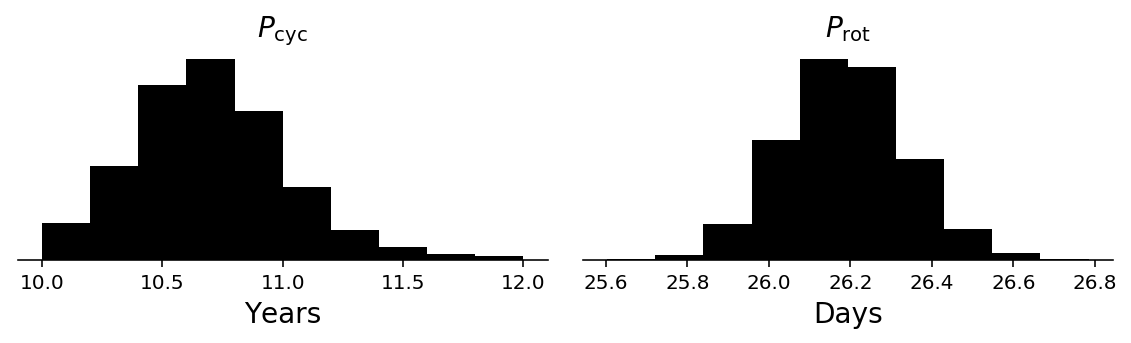

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
# ax[0].hist(2*np.pi/np.exp(sampler.flatchain[:, -1]) / 365, histtype='stepfilled', color='k')
# ax[1].hist(2*np.pi/( np.exp(sampler.flatchain[:, 2])) , histtype='stepfilled', color='k')
# ax[2].hist(2*np.pi/np.exp(sampler.flatchain[:, 2])/365, histtype='stepfilled', color='k')

ax[0].hist(np.exp(sampler.flatchain[:, 2])/ 365, histtype='stepfilled', color='k')
ax[1].hist(np.exp(sampler.flatchain[:, -1]), histtype='stepfilled', color='k')
# ax[2].hist(np.exp(sampler.flatchain[:, 4]), histtype='stepfilled', color='k')

for axis in ax:
    for s in 'right top left'.split():
        axis.spines[s].set_visible(False)
    axis.set_yticks([])
fontsize = 14
ax[1].set_xlabel('Days', fontsize=fontsize)
ax[1].set_title('$P_\mathrm{rot}$', fontsize=fontsize)
ax[0].set_xlabel('Years', fontsize=fontsize)
ax[0].set_title('$P_\mathrm{cyc}$', fontsize=fontsize)
fig.tight_layout()
fig.savefig('paper_plots/periods.pdf', bbox_inches='tight')

In [29]:
prot = np.exp(sampler.flatchain[:, 2])/365
pcyc = np.exp(sampler.flatchain[:, -1])

print(prot.mean(), prot.std())
print(pcyc.mean(), pcyc.std())

10.7035130612 0.32013656456
26.1875931089 0.14923018537


In [30]:
d = gp.kernel.get_parameter_dict()
print(d)

OrderedDict([('terms[0]:log_a', -20.0), ('terms[0]:log_c', -9.0), ('terms[0]:log_P', 8.2512726107459695), ('terms[1]:log_a', -20.0), ('terms[1]:log_P', 5.8998973535824915), ('terms[2]:log_a', -20.0), ('terms[2]:log_c', -2.0), ('terms[2]:log_P', 3.2580965380214821)])


In [31]:
np.median(sampler.flatchain, axis=0)

array([-19.32324648, -10.3780917 ,   8.26860295, -21.41159887,
         5.90076005, -19.59876605,  -4.14557681,   3.265189  ])

In [32]:
gp.kernel.get_parameter_names()

('terms[0]:log_a',
 'terms[0]:log_c',
 'terms[0]:log_P',
 'terms[1]:log_a',
 'terms[1]:log_P',
 'terms[2]:log_a',
 'terms[2]:log_c',
 'terms[2]:log_P')

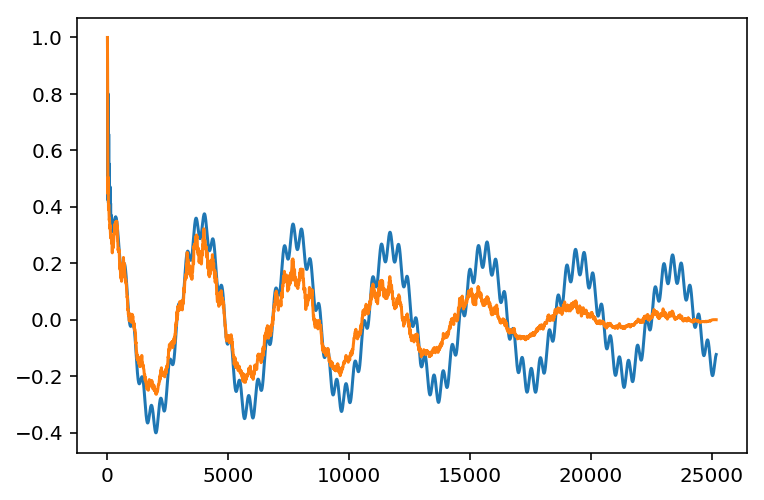

In [33]:
lags = np.arange(len(acf_measured))

gp.kernel.set_parameter_vector(np.median(sampler.flatchain, axis=0))

acf_model = gp.kernel.get_value(lags)

plt.plot(lags, acf_model/acf_model.max())
plt.plot(lags, acf_measured/acf_measured.max())
# plt.xlim([0, 365*10])
# plt.xlim([0, 365*2])
# plt.xlim([0, 100])